In [57]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, shapiro
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse

# Visualization

## Alpha diversity

### Data load

In [58]:
# 경고 메시지 숨기기
warnings.filterwarnings("ignore")

# 데이터 불러오기 및 전처리
df2 = pd.read_csv('df_genus_3.csv')
df2 = df2.transpose()
df2.columns = df2.iloc[0]
df2 = df2.iloc[1:]
df2 = df2[[col for col in df2.columns if 'g__' in col]]
grouped = df2.groupby(lambda col: col.split(';g__', 1)[-1].split(';')[0], axis=1).sum()
col_list = grouped.columns
df2 = grouped

# 'g__'를 열 이름에서 제거하여 수정
new_columns = [col.replace('g__', '') for col in df2.columns]
df2.columns = new_columns

# 환자와 정상 그룹 분리
patient = df2[df2.index.str.startswith('7')]
normal = df2[~df2.index.str.startswith('7')]

# 'class' 열 추가
df2['class'] = ['patient' if index.startswith('7') else 'normal' for index in df2.index]
df2.to_csv('df2.csv')
df2

,Acetanaerobacterium,Acidaminococcus,Actinobacillus,Actinomyces,Adlercreutzia,Aerococcus,Agathobacter,Aggregatibacter,Akkermansia,Alistipes,...,[Eubacterium]_ruminantium_group,[Eubacterium]_siraeum_group,[Eubacterium]_ventriosum_group,[Eubacterium]_xylanophilum_group,[Ruminococcus]_gauvreauii_group,[Ruminococcus]_gnavus_group,[Ruminococcus]_torques_group,uncultured,vadinBE97,class
100033.0,0.000000,0.000000,0.0,0.0,0.000077,0.0,0.003954,0.000000,0.000000,0.093576,...,0.000000,0.000000,0.001854,0.001421,0.00000,0.000000,0.000711,0.004371,0.000000,normal
100043.0,0.000000,0.001162,0.0,0.0,0.000039,0.0,0.007139,0.000000,0.005716,0.006747,...,0.001475,0.000000,0.004868,0.000000,0.00047,0.000261,0.000131,0.000757,0.000052,normal
100052.0,0.000000,0.000000,0.0,0.0,0.001761,0.0,0.000000,0.000000,0.114730,0.004542,...,0.000000,0.001267,0.000000,0.000000,0.00411,0.000649,0.000958,0.031548,0.000000,normal
100058.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.018173,0.000000,0.008553,0.023701,...,0.000000,0.000000,0.002789,0.000000,0.00000,0.004921,0.005640,0.009260,0.000000,normal
100067.0,0.000587,0.000000,0.0,0.0,0.000031,0.0,0.001421,0.000000,0.110267,0.006161,...,0.000000,0.000000,0.002347,0.000000,0.00000,0.000479,0.002393,0.000108,0.000000,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92044.0,0.000389,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.109601,0.001455,...,0.000000,0.000000,0.006758,0.000375,0.00000,0.002680,0.000865,0.000893,0.000000,normal
92056.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.026187,0.000000,0.000039,0.068901,...,0.000000,0.000000,0.003595,0.000000,0.00000,0.002013,0.007308,0.005203,0.000000,normal
99011.0,0.000000,0.000000,0.0,0.0,0.000114,0.0,0.000000,0.000034,0.006894,0.016476,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.037959,0.001120,0.056813,0.000000,normal
99061.0,0.000000,0.000239,0.0,0.0,0.000000,0.0,0.005418,0.000000,0.018886,0.039008,...,0.000124,0.000479,0.001637,0.001761,0.00000,0.000325,0.005552,0.025960,0.000000,normal


### 시각화

In [59]:
# 다양성 구하는 함수들 (chao1, shannon, simson, observed_otus)

# Simple diversity calculation functions
def calculate_chao1(data):
    observed = np.sum(data > 0)
    chao1 = observed + ((observed**2) / (2 * np.sum(data)))
    return chao1

def calculate_shannon(data):
    non_zero_data = data[data > 0]
    proportions = non_zero_data / np.sum(non_zero_data)
    shannon = -np.sum(proportions * np.log(proportions))
    return shannon

def calculate_simpson(data):
    proportions = data / np.sum(data)
    simpson = 1 - np.sum(proportions**2)
    return simpson

def calculate_observed_otus(data):
    observed_otus = np.sum(data > 0)
    return observed_otus

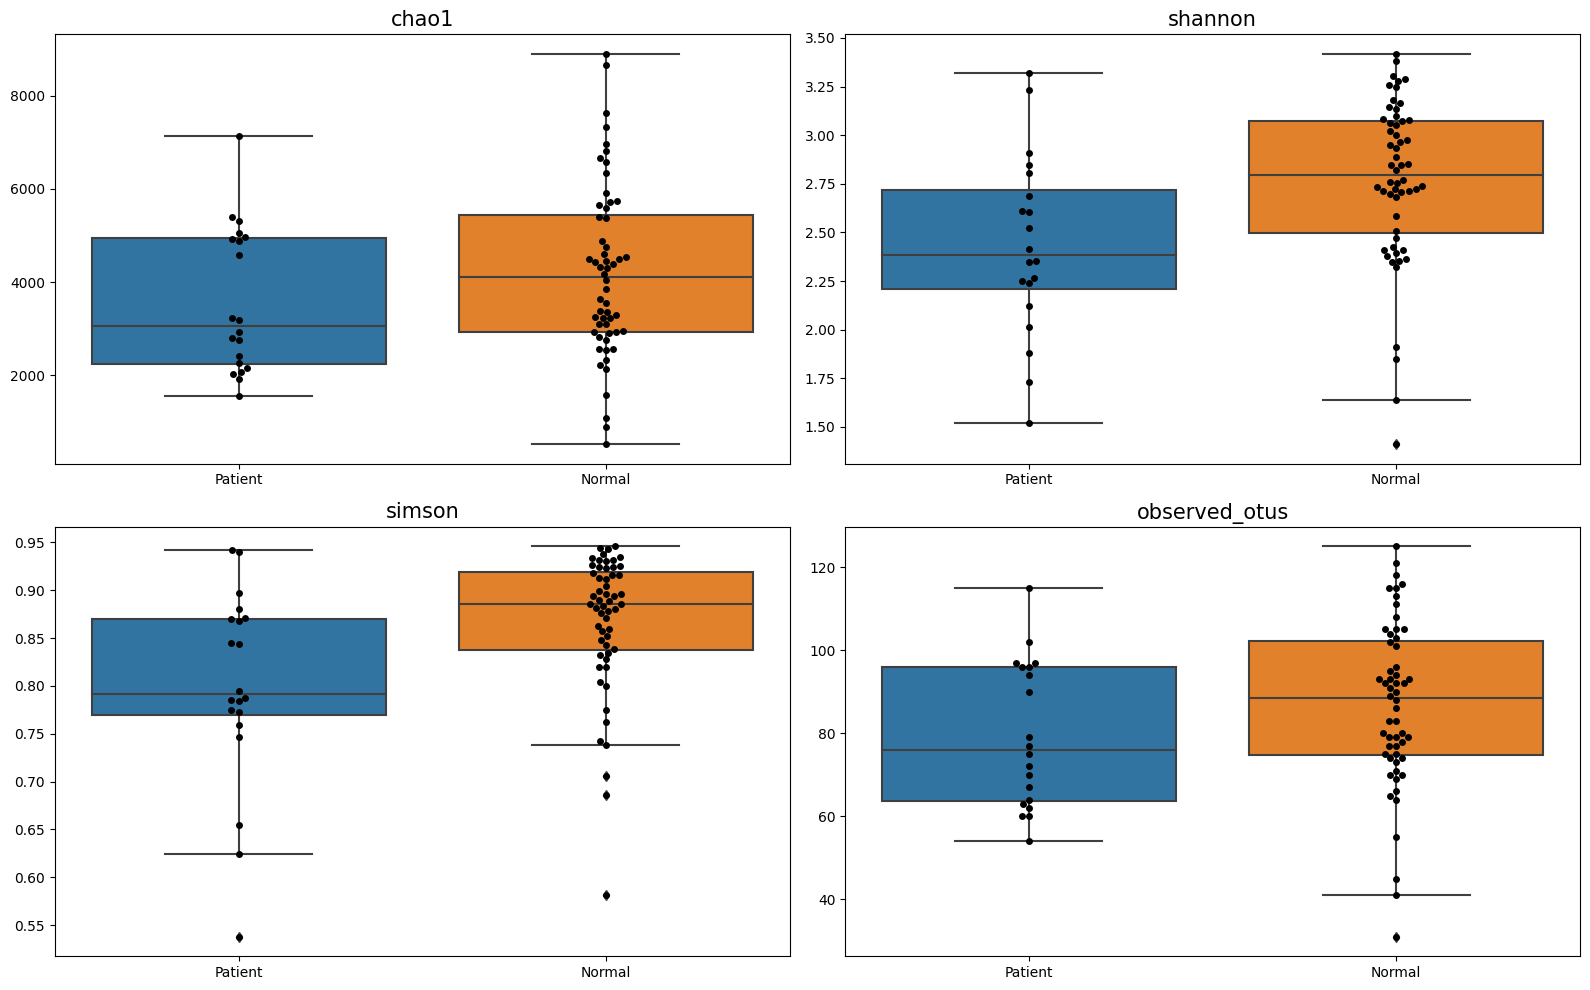

In [60]:
# 함수 사전 생성
func_dict = {'chao1' : calculate_chao1,
             'shannon' : calculate_shannon,
             'simson' : calculate_simpson,
             'observed_otus' : calculate_observed_otus}

# 그룹에 따른 다양성 지수 계산
val_dict = {}
for name, func in func_dict.items():
    val_dict[name] = [patient.apply(func, axis=1),
                      normal.apply(func, axis=1)]
    
# 다양성 지수에 따른 데이터프레임 생성
df_dict = {}
for name in func_dict.keys():
    tmp_df = pd.DataFrame({'Patient': val_dict[name][0], 'Normal': val_dict[name][1]})
    df_dict[name] = tmp_df.reset_index().melt(id_vars='index', var_name='Group', value_name = name)
    
# 시각화
plt.figure(figsize=(16, 10))
for i,name in enumerate(func_dict.keys()):
    plt.subplot(2, 2, i+1)
    sns.boxplot(data=df_dict[name], x='Group', y=name)
    sns.swarmplot(data=df_dict[name], x='Group', y=name, color='black')
    plt.title(name,size=15)
    plt.xticks(size=10)
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

### 통계적 검정  
- 정규성 확인 (확인 결과 대부분 정규성 위배)
- Mann-Whitney 검정 실행 (비모수)
- p-value 값이 작은 상위 8개의 변수를 골라 plot 을 그려 확인 (p-value 값이 작을수록 patient, normal 간 차이가 크다고 판단)
- scree plot 을 그려 최적의 PCA 수를 구함
- PCA plot 그림

In [61]:
# Mann-Whitney U 검정 (비모수검정)
significant_columns = []
p_values = []
# 열별로 Mann-Whitney U 검정 진행
for col in df2.columns[:-1]:  # 'class' 열 제외
    stat, p_value = mannwhitneyu(patient[col], normal[col])
    if p_value < 0.05:  # 유의수준 0.05로 설정
        significant_columns.append(col)
        p_values.append(p_value)
        
series = pd.Series(p_values, index=significant_columns)
significant_df = series.to_frame(name='p-value').sort_values(by='p-value')

print('유의미한 변수 개수: ',len(series), '개')

유의미한 변수 개수:  41 개


In [62]:
import pickle

# 모델링에 사용하기위해 피클파일로 저장
with open('significant_df.pkl', 'wb') as f:
    pickle.dump(significant_df, f)

In [63]:
# p-value 값이 작은 상위 8개 변수
significant_df.head(8)

,p-value
Bifidobacterium,0.000286
Collinsella,0.000467
Incertae_Sedis,0.000548
Parasutterella,0.001019
Dorea,0.001569
Phascolarctobacterium,0.001903
Erysipelotrichaceae_UCG-003,0.002302
Sutterella,0.002579


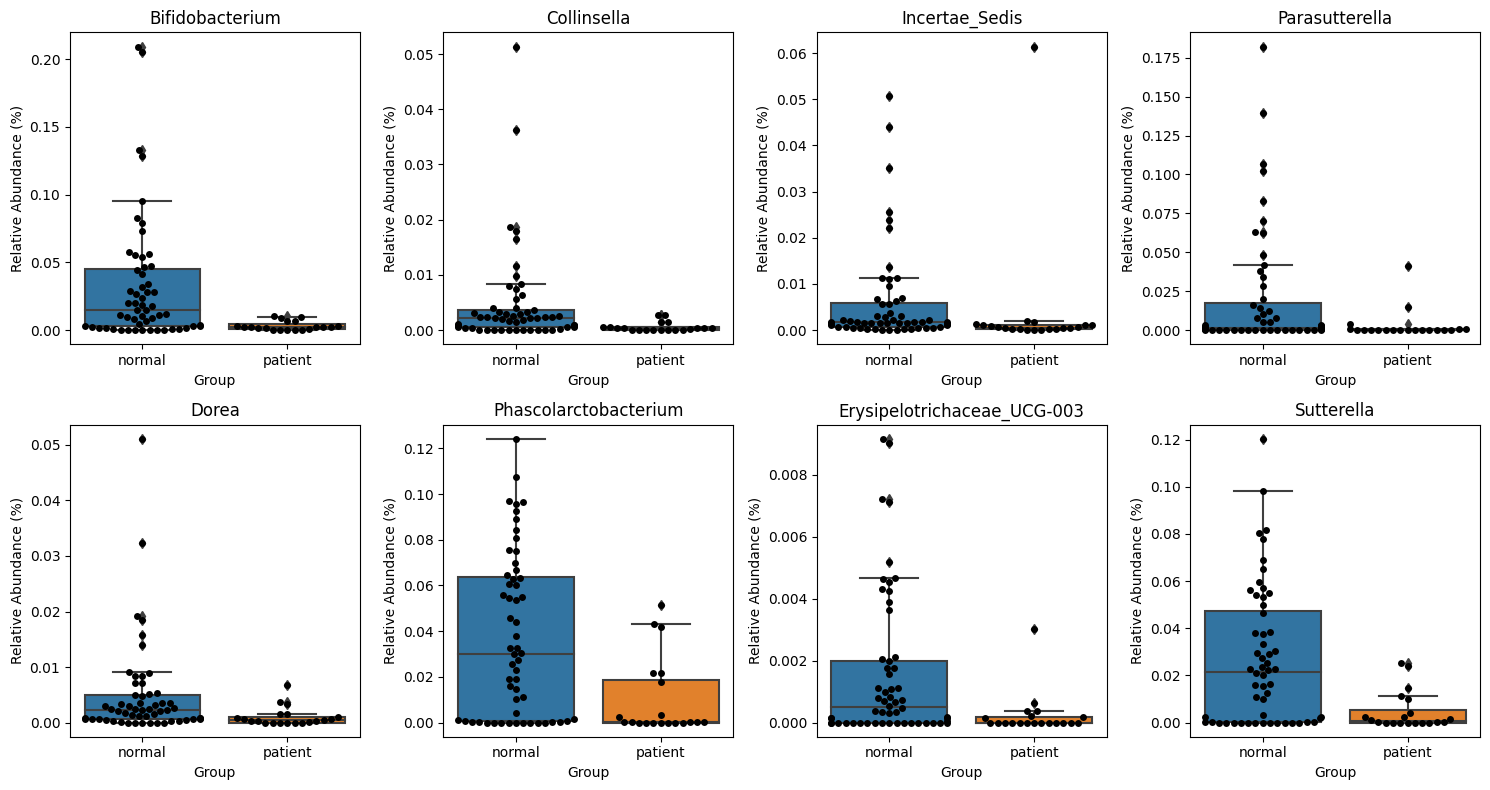

In [64]:
# p-value 값이 작은 상위 8개 변수의 class별 boxplot

plt.figure(figsize=(15,8))
for i in range(8):
    col = significant_df.index[i]
    plt.subplot(2,4,i+1)
    sns.boxplot(data=df2, x='class',y=col)
    sns.swarmplot(data=df2, x='class', y=col, color='black', size=5)
    plt.title(col)
    plt.xlabel('Group')
    plt.ylabel('Relative Abundance (%)')

plt.tight_layout()
plt.show()

## PCA

- 최적의 PCA 수를 선정하기 위해 scree plot을 그려보았음
    - 확인 결과 2를 선정
- 클래스 별로 주성분 벡터와 분산을 활용하여 타원 수행


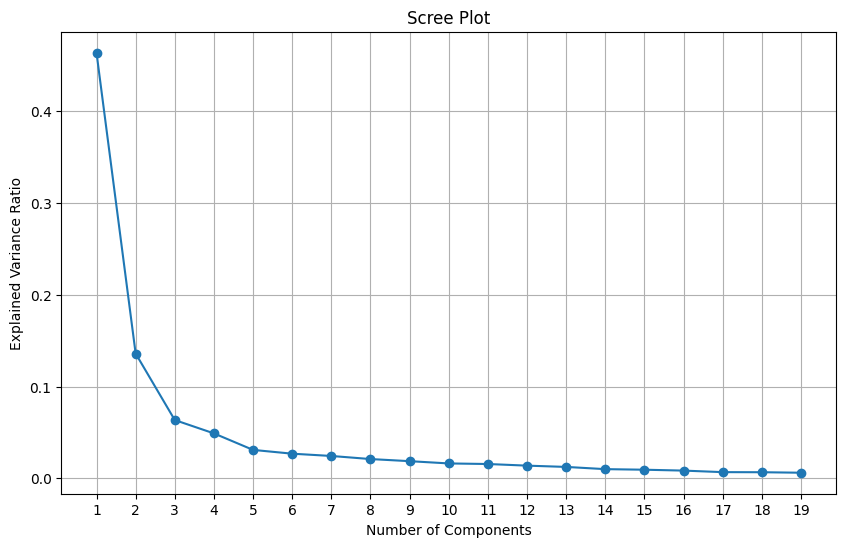

In [65]:
# 최적의 PCA 수 선정하기
# scree plot
# 'class' 열을 기준으로 'patient'와 'normal' 구분하여 데이터프레임 생성
df_pca = df2[df2['class'].isin(['patient', 'normal'])]

# PCA 수행하여 설명 분산 구하기
pca = PCA()
pca.fit(df_pca.iloc[:, :-1])

# Scree plot 그리기
explained_variance_ratio = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), explained_variance_ratio[:19], marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, 20))
plt.grid(True)
plt.show()

### 전체 변수 활용

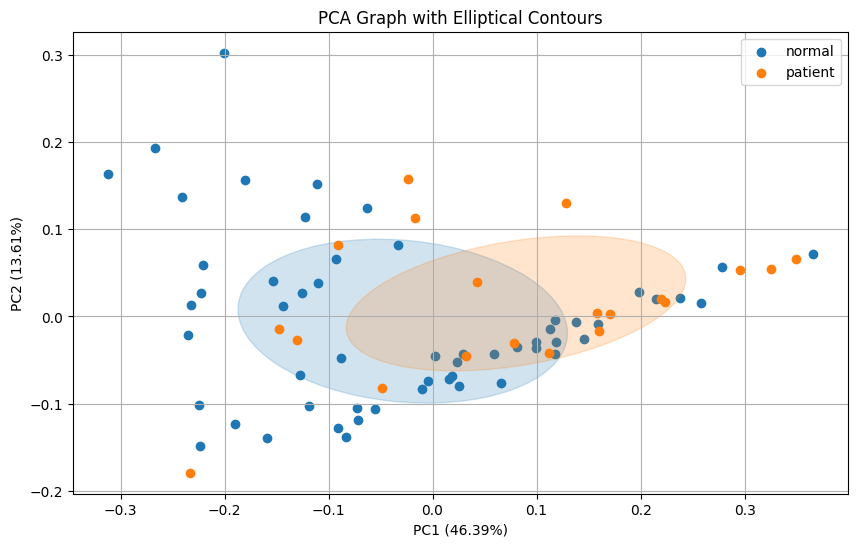

In [66]:
# Scree plot을 통해 최적의 PCA 수를 구했음

# 'class' 열을 기준으로 'patient'와 'normal' 구분하여 데이터프레임 생성
df_pca = df2[df2['class'].isin(['patient', 'normal'])]

# 'class' 열 제외한 열에 대해 PCA 수행
pca = PCA(n_components=2)
pca_result = pd.DataFrame(pca.fit_transform(df_pca.iloc[:, :-1]))

# 주성분 벡터와 분산 가져오기
components = pca.components_
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_

# 그래프 그리기
plt.figure(figsize=(10, 6))

# 클래스 별로 주성분 벡터와 분산을 활용하여 타원 그리기
for i, class_name in enumerate(df_pca['class'].unique()):
    class_indices = np.where(df2['class'] == class_name)[0]

    scatter = plt.scatter(pca_result.iloc[class_indices, 0],
                pca_result.iloc[class_indices, 1],
                label=class_name)

    # 공분산 계산
    class_samples = pca_result.iloc[class_indices, :]
    cov_matrix = np.cov(class_samples, rowvar=False)

    # 주성분 계산
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    angle = np.degrees(np.arctan(eigenvectors[1, 0].real / eigenvectors[0, 0].real))  # 실수값만 활용
    width, height = np.sqrt(eigenvalues[0]),np.sqrt(eigenvalues[1])

    # 타원 생성
    ellipse = Ellipse(xy=(np.mean(class_samples.iloc[:, 0]), np.mean(class_samples.iloc[:, 1])),
                      width=width * 2, height=height * 2,
                      angle=angle, color=scatter.get_facecolor()[0], alpha=0.2)

    # 타원 추가
    plt.gca().add_patch(ellipse)

# x축과 y축에 PCoA 값의 비율 표시
plt.xlabel(f'PC1 ({explained_variance_ratio[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]*100:.2f}%)')

plt.title('PCA Graph with Elliptical Contours')
plt.legend()
plt.grid(True)
plt.show()


### 유의미한 변수만을 사용

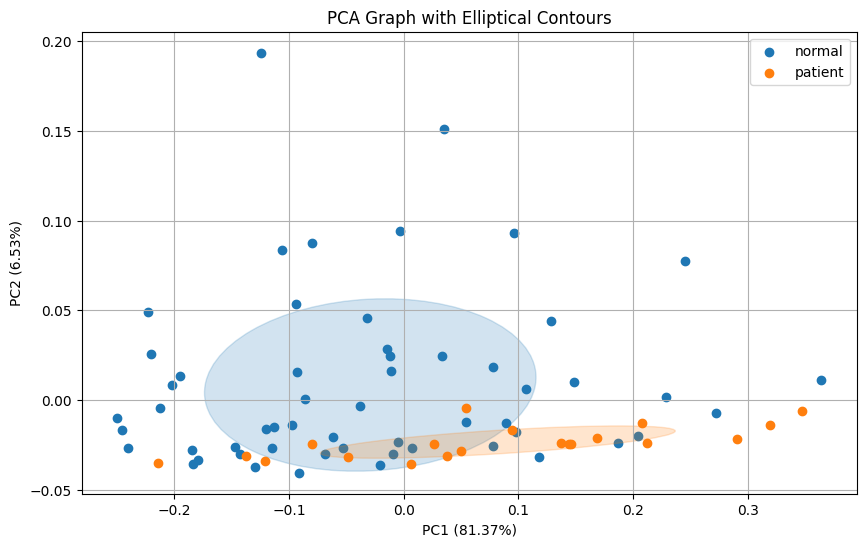

In [67]:
# 'class' 열을 기준으로 'patient'와 'normal' 구분하여 데이터프레임 생성
df_pca = df2[df2['class'].isin(['patient', 'normal'])]

# 선택된 유의미한 변수만으로 데이터프레임 업데이트
df_selected = df_pca[['class'] + list(significant_df.index)]

# 선택된 변수에 대해 PCA 수행
pca = PCA(n_components=2)
pca_result = pd.DataFrame(pca.fit_transform(df_selected.iloc[:, 1:]))  # 'class' 열 제외

# 주성분 벡터와 분산 가져오기
components = pca.components_
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_

# 그래프 그리기
plt.figure(figsize=(10, 6))

# 클래스 별로 주성분 벡터와 분산을 활용하여 타원 그리기
for i, class_name in enumerate(df_pca['class'].unique()):
    class_indices = np.where(df2['class'] == class_name)[0]

    scatter = plt.scatter(pca_result.iloc[class_indices, 0],
                pca_result.iloc[class_indices, 1],
                label=class_name)

    # 공분산 계산
    class_samples = pca_result.iloc[class_indices, :]
    cov_matrix = np.cov(class_samples, rowvar=False)

    # 주성분 계산
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    angle = np.degrees(np.arctan(eigenvectors[1, 0].real / eigenvectors[0, 0].real))  # 실수값만 활용
    width, height = np.sqrt(eigenvalues[0]),np.sqrt(eigenvalues[1])
    
    # 타원 생성
    ellipse = Ellipse(xy=(np.mean(class_samples.iloc[:, 0]), np.mean(class_samples.iloc[:, 1])),
                      width=width * 2, height=height * 2,
                      angle=angle, color=scatter.get_facecolor()[0], alpha=0.2)

    # 타원 추가
    plt.gca().add_patch(ellipse)

# x축과 y축에 PCoA 값의 비율 표시
plt.xlabel(f'PC1 ({explained_variance_ratio[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]*100:.2f}%)')

plt.title('PCA Graph with Elliptical Contours')
plt.legend()
plt.grid(True)
plt.show()


## Beta diversity
- Bray-Curtis 방식으로 PCoA plot
  - 전체 변수를 활용한 plot
  - 유의미한 변수를 활용한 plot

- Weighted UniFrac Distance를 통한 PCoA plot


In [76]:
!pip install scikit-bio

In [68]:
from skbio.stats.ordination import pcoa
from skbio import DistanceMatrix
from scipy.spatial.distance import pdist

### 전체 변수활용 PCoA

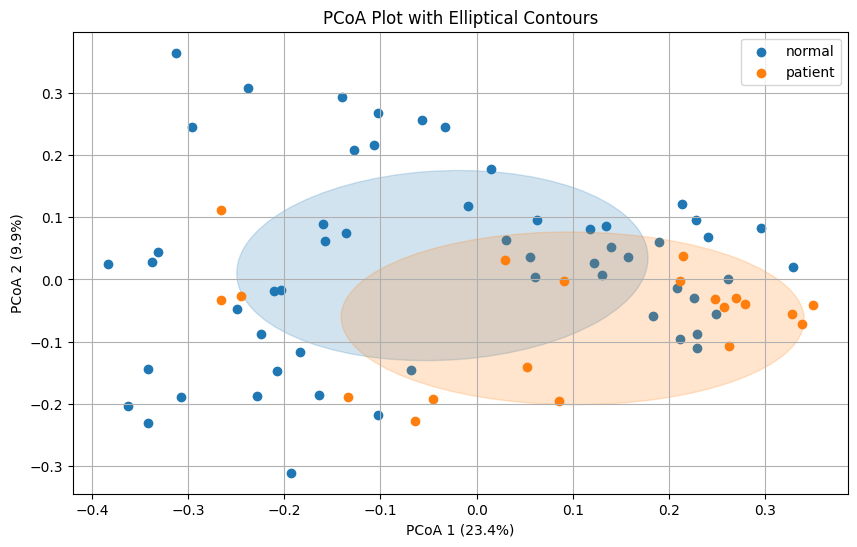

In [69]:
# Bray-Curtis 거리 계산
braycurtis_distance = DistanceMatrix(pdist(df2.drop('class', axis=1), metric='braycurtis'))

# PCoA 수행
pcoa_results = pcoa(braycurtis_distance)

# PCoA 결과 시각화
plt.figure(figsize=(10, 6))

# 클래스 레이블 확인
class_labels = df2['class'].unique()

# 각 클래스 별로 산점도 작성 및 elliptical contours 추가
for i, class_label in enumerate(class_labels):
    class_indices = np.where(df2['class'] == class_label)[0]

    # Scatter plot
    scatter = plt.scatter(pcoa_results.samples.iloc[class_indices, 0],
                pcoa_results.samples.iloc[class_indices, 1],
                label=class_label)

    # 공분산 계산
    class_samples = pcoa_results.samples.iloc[class_indices, :]
    cov_matrix = np.cov(class_samples, rowvar=False)

    # 주성분 계산
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    angle = np.degrees(np.arctan(eigenvectors[1, 0].real / eigenvectors[0, 0].real))  # 실수값만 활용
    width, height = np.sqrt(eigenvalues[0]),np.sqrt(eigenvalues[1])

    # 타원 생성
    ellipse = Ellipse(xy=(np.mean(class_samples.iloc[:, 0]), np.mean(class_samples.iloc[:, 1])),
                      width=width * 2, height=height * 2,
                      angle=angle, color=scatter.get_facecolor()[0], alpha=0.2)

    # 타원 추가
    plt.gca().add_patch(ellipse)

# x축과 y축에 PCoA 값의 비율 표시
plt.xlabel(f'PCoA 1 ({pcoa_results.proportion_explained[0]*100:.1f}%)')
plt.ylabel(f'PCoA 2 ({pcoa_results.proportion_explained[1]*100:.1f}%)')

plt.title('PCoA Plot with Elliptical Contours')
plt.legend()
plt.grid(True)
plt.show()

### 유의미한 변수만 사용한 PCoA

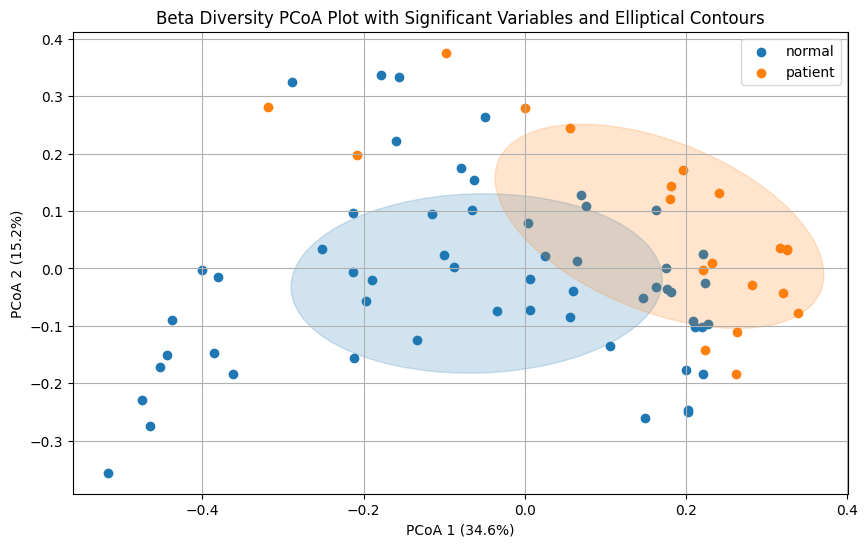

In [70]:
# 유의미한 변수만 추출한 데이터프레임 생성
df_selected = df2[significant_df.index].copy()

# Bray-Curtis 거리 계산
braycurtis_distance_significant = DistanceMatrix(pdist(df_selected, metric='braycurtis'))

# PCoA 수행
pcoa_results_significant = pcoa(braycurtis_distance_significant)

# PCoA 결과 시각화
plt.figure(figsize=(10, 6))

# 클래스 레이블 확인
class_labels = df2['class'].unique()

# 각 클래스 별로 산점도 작성 및 elliptical contours 추가
for i, class_label in enumerate(class_labels):
    class_indices = np.where(df2['class'] == class_label)[0]

    # Scatter plot
    scatter = plt.scatter(pcoa_results_significant.samples.iloc[class_indices, 0],
                pcoa_results_significant.samples.iloc[class_indices, 1],
                label=class_label)

    # 공분산 계산
    class_samples = pcoa_results_significant.samples.iloc[class_indices, :]
    cov_matrix = np.cov(class_samples, rowvar=False)

    # 주성분 계산
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    angle = np.degrees(np.arctan(eigenvectors[1, 0].real / eigenvectors[0, 0].real))
    width = np.sqrt(eigenvalues[0])
    height = np.sqrt(eigenvalues[1])

    # 타원 생성
    ellipse = Ellipse(xy=(np.mean(class_samples.iloc[:, 0]), np.mean(class_samples.iloc[:, 1])),
                      width=width * 2, height=height * 2,
                      angle=angle, color=scatter.get_facecolor()[0], alpha=0.2)

    # 타원 추가
    plt.gca().add_patch(ellipse)

# x축과 y축에 PCoA 값의 비율 표시
plt.xlabel(f'PCoA 1 ({pcoa_results_significant.proportion_explained[0]*100:.1f}%)')
plt.ylabel(f'PCoA 2 ({pcoa_results_significant.proportion_explained[1]*100:.1f}%)')

plt.title('Beta Diversity PCoA Plot with Significant Variables and Elliptical Contours')
plt.legend()
plt.grid(True)
plt.show()

### Jaccard Distance를 통한 PCoA

In [71]:
from skbio.diversity import beta_diversity

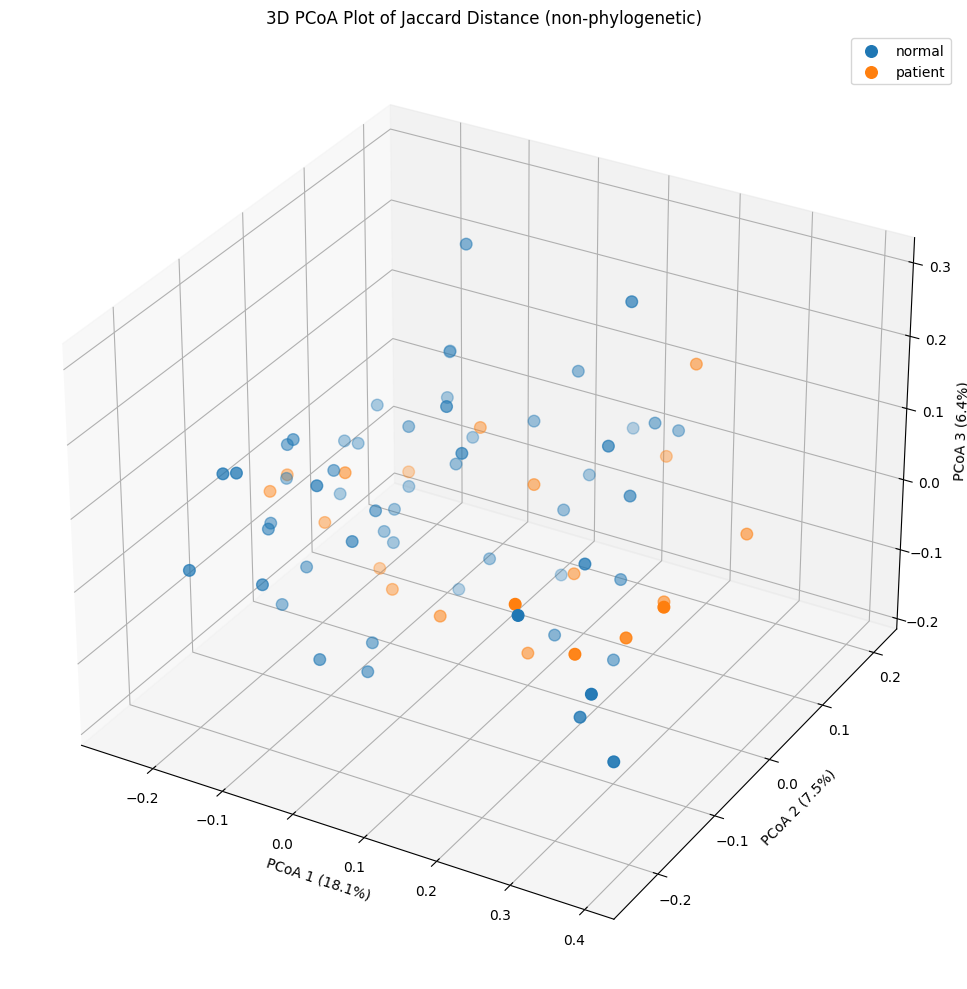

In [72]:
# 데이터 준비
data = df2.drop(columns=['class'])

# 데이터 이진 변환
binary_data = (data > 0).astype(int)

# Jaccard Distance 계산 (phylogenetic=False 옵션 사용)
jaccard_distance = beta_diversity(metric="jaccard", counts=binary_data.values)

# Distance Matrix 생성
distance_matrix = jaccard_distance.data

# PCoA 수행
pcoa_results = pcoa(distance_matrix)

# 샘플의 클래스에 따라 색상 설정
colors = {'normal': 'blue', 'patient': 'red'}
sample_colors = [colors[class_] for class_ in df2['class']]

# 3D PCoA 결과 시각화
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for i, class_label in enumerate(class_labels):
    class_indices = np.where(df2['class'] == class_label)[0]
    scatter = ax.scatter(pcoa_results.samples.values[class_indices, 0], pcoa_results.samples.values[class_indices, 1], pcoa_results.samples.values[class_indices, 2], s=70)

# PCoA 값의 비율을 레이블에 표시
ax.set_xlabel(f'PCoA 1 ({pcoa_results.proportion_explained[0]*100:.1f}%)')
ax.set_ylabel(f'PCoA 2 ({pcoa_results.proportion_explained[1]*100:.1f}%)')
ax.set_zlabel(f'PCoA 3 ({pcoa_results.proportion_explained[2]*100:.1f}%)')

ax.set_title("3D PCoA Plot of Jaccard Distance (non-phylogenetic)")

# 그래프 크기 조절 및 축 범위 설정
plt.legend(labels = colors)
plt.tight_layout()
plt.show()

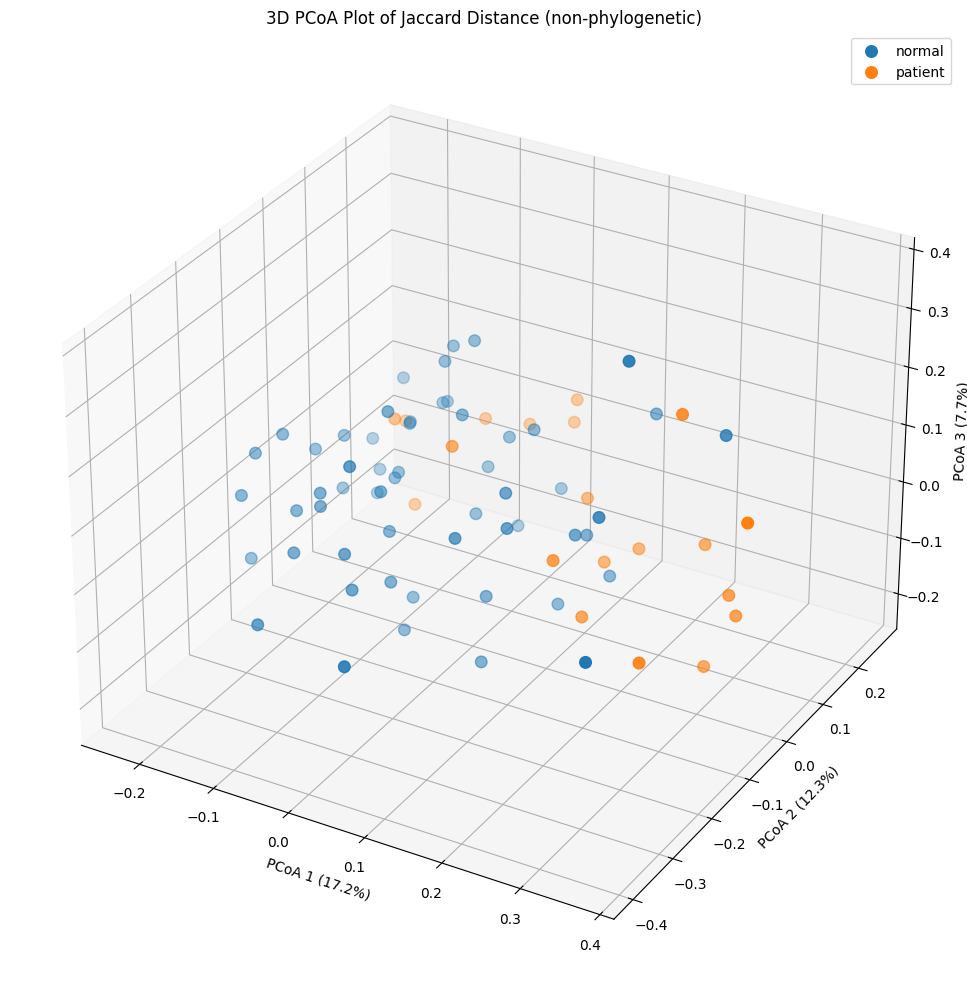

In [56]:
# 유의미한 변수만 추출하여 데이터 생성
significant_data = df2[significant_df.index]

# 데이터 이진 변환
significant_binary_data = (significant_data > 0).astype(int)

# Jaccard Distance 계산 (phylogenetic=False 옵션 사용)
jaccard_distance = beta_diversity(metric="jaccard", counts=significant_binary_data.values)

# Distance Matrix 생성
distance_matrix = jaccard_distance.data

# PCoA 수행
pcoa_results = pcoa(distance_matrix)

# 샘플의 클래스에 따라 색상 설정
colors = {'normal': 'blue', 'patient': 'red'}
sample_colors = [colors[class_] for class_ in df2['class']]

# 3D PCoA 결과 시각화
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for i, class_label in enumerate(class_labels):
    class_indices = np.where(df2['class'] == class_label)[0]
    scatter = ax.scatter(pcoa_results.samples.values[class_indices, 0], pcoa_results.samples.values[class_indices, 1], pcoa_results.samples.values[class_indices, 2], s=70)
# PCoA 값의 비율을 레이블에 표시
ax.set_xlabel(f'PCoA 1 ({pcoa_results.proportion_explained[0]*100:.1f}%)')
ax.set_ylabel(f'PCoA 2 ({pcoa_results.proportion_explained[1]*100:.1f}%)')
ax.set_zlabel(f'PCoA 3 ({pcoa_results.proportion_explained[2]*100:.1f}%)')

ax.set_title("3D PCoA Plot of Jaccard Distance (non-phylogenetic)")

# 그래프 크기 조절 및 축 범위 설정
plt.tight_layout()
plt.legend(labels = colors)
plt.show()